In [1]:
import matplotlib.image as mpimg
import scipy.misc as spmisc
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
# NOTE: the next import is only valid
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

from scipy.ndimage.measurements import label

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

from collections import deque

In [2]:
%matplotlib inline

# Load Data

In [3]:
# helper function to show images/labels in dataset
# rows and cols define the grid of plots
# cls, if specified, only shows images from that class
# random flag identifies if we want random selection or just wanna see the full dataset
# if labels_predicted passed in, we visualise them too
def show_images(images, labels_true, rows, cols, cls=None, random=True, labels_predicted=None):
    fig, axes = plt.subplots(rows, cols)
    fig.subplots_adjust(hspace=0.37, wspace=0.3)
    imidx = 0
    for i, ax in enumerate(axes.flat):
        while True:
            if random:
                example = np.random.randint(0, len(images))
            else:
                example = imidx
                imidx += 1
            if cls is None or labels_true[example]==cls:
                break
        if example >= len(images):
            return
        if len(images.shape)==4:
            ax.imshow(images[example,:,:,:]);
        else:
            ax.imshow(images[example,:,:], cmap='Greys_r');
        ax.set_xticks([])
        ax.set_yticks([])
        if labels_predicted is not None:
            str = '{}: true {} pred {}'.format(example, labels_true[example], labels_predicted[example])
        else:
            str = '{}: true {}'.format(example, labels_true[example])
        ax.set_xlabel(str)

In [4]:
# the color space of the input images
default_color_space = 'RGB'

In [ ]:
# helper to read an image. adds ability to change underlying implementation of image reading function
def read_image(file):
    return spmisc.imread(file, mode=default_color_space)

In [5]:
# helper function to read in all images in specified path (can have unix-type wildcards)
def read_image_data(path):
    files = glob.glob(path)
    images = np.array([read_image(f) for f in files])
    return files, images

In [6]:
# Read in vehicles data
car_files, car_images = read_image_data('data/vehicles/*/*.*')

print('number of car files: {}'.format(len(car_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in car_files])))
print('car images array shape: {}'.format(car_images.shape))

number of car files: 8792
unique file extensions: ['.png']
car images array shape: (8792, 64, 64, 3)


In [7]:
# Read in NON-vehicles data
noncar_files, noncar_images = read_image_data('data/non-vehicles/*/*.*')

print('number of non-car files: {}'.format(len(noncar_files)))
print('unique file extensions: {}'.format(np.unique([c[c.rfind('.'):] for c in noncar_files])))
print('non-car images array shape: {}'.format(noncar_images.shape))

number of non-car files: 8968
unique file extensions: ['.png']
non-car images array shape: (8968, 64, 64, 3)


In [8]:
# combine data. the classes are quite balanced
allimages = np.vstack([car_images, noncar_images])
alllabels = np.hstack([np.ones(len(car_images)), np.zeros(len(noncar_images))]).astype(np.uint8)

In [9]:
allimages.shape

(17760, 64, 64, 3)

In [10]:
alllabels.shape

(17760,)

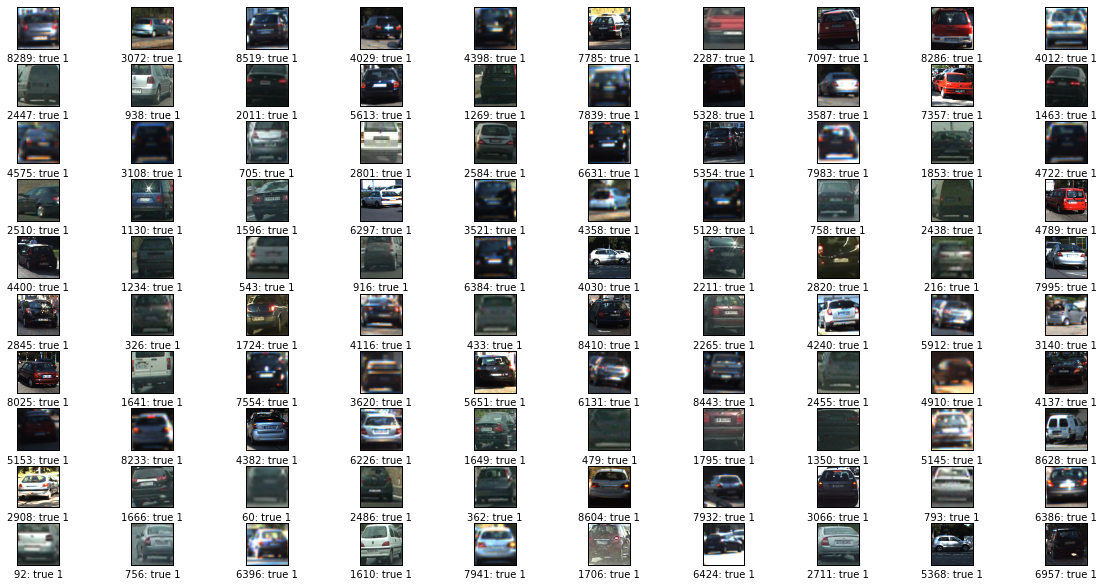

In [11]:
# visualize cars
show_images(allimages, alllabels, 10, 10, cls=1)

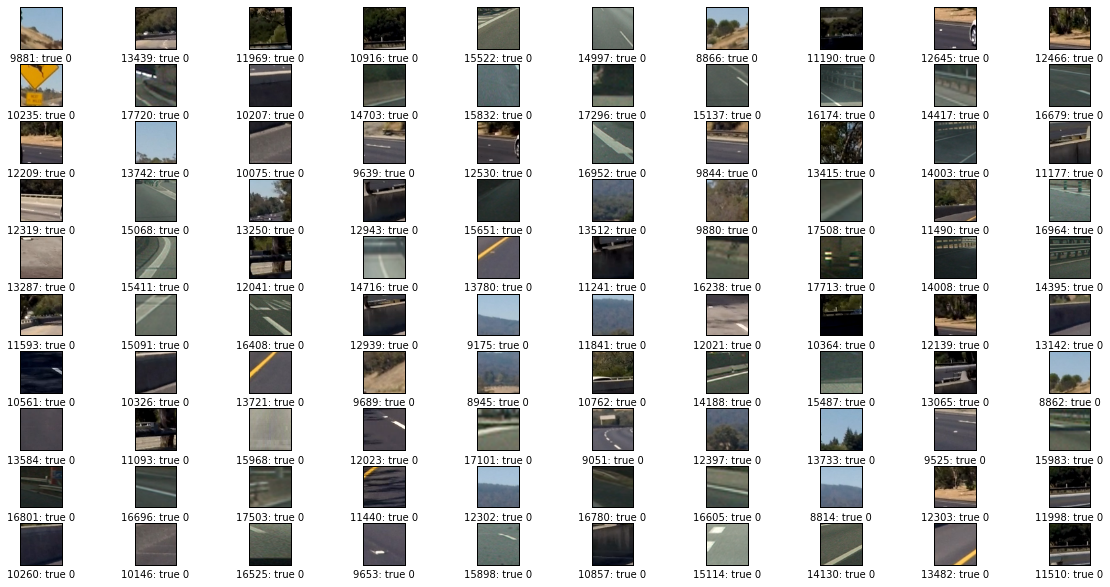

In [12]:
# visualize NON-cars
show_images(allimages, alllabels, 10, 10, cls=0)

# load test images

In [17]:
image = read_image('test_images/test5.jpg')
#image = read_image('test_images/mytest1.jpg')
plt.imshow(image);
image.shape

(720, 1280, 3)

In [19]:
carimage = car_images[100]
plt.figure(figsize=(3,3))
plt.imshow(carimage);

# define features

In [21]:
# helper function to convert colorspace of the image. uses OpenCV implementation
def convert_color(img, from_colorspace=default_color_space, to_colorspace=default_color_space):
    if (from_colorspace==to_colorspace):
        tmpimg = img
    else:
        convstr = 'cv2.COLOR_'+from_colorspace+'2'+to_colorspace
        cv2color = eval(convstr)
        tmpimg = cv2.cvtColor(img, cv2color)
    return tmpimg

In [22]:
# helper function to resize the image. uses OpenCV implementation
def image_resize(img, size):
    small_img = cv2.resize(img, size)
    return small_img

## spatial features

In [23]:
# compute spatial features (essentially image pixels)
def features_spatial(img, size=(32, 32), feature_vec=True):
    small_img = image_resize(img, size)
    if feature_vec:
        features = small_img.ravel()
    else:
        features = small_img
    return features

In [ ]:
spatial_colorspace='RGB'
tmpimg = convert_color(carimage, to_colorspace=spatial_colorspace)

In [24]:
small_image_size = (32,32)
feature_vec=True

In [25]:
feature_vec = features_spatial(carimage, size=small_image_size, feature_vec=feature_vec)
feature_vec.shape

(3072,)

In [26]:
feature_vec

array([120, 128, 112, ...,  64,  71,  67], dtype=uint8)

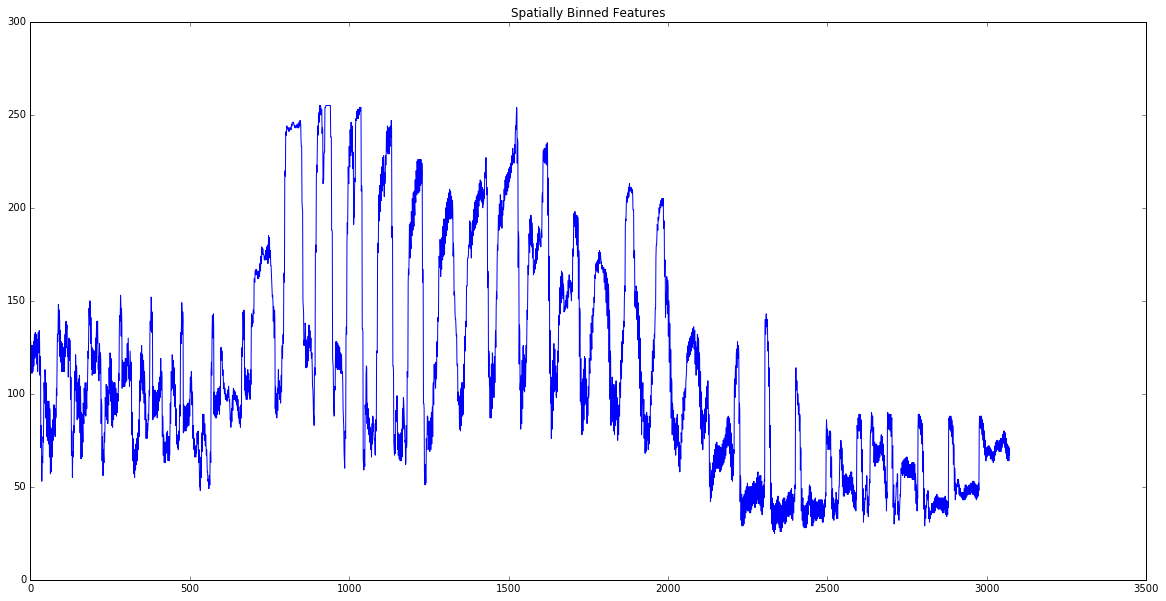

In [27]:
plt.plot(feature_vec)
plt.title('Spatially Binned Features');

## color histogram features

In [28]:
# compute color histogram features 
# nbins is number of histogram bins
# bins_range defines the range of pixel values we cover by historgam
def features_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Generating bin centers
    bin_edges = channel1_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    return hist_features, bin_centers

In [ ]:
spatial_colorspace='YUV'
tmpimg = convert_color(carimage, to_colorspace=spatial_colorspace)

In [29]:
num_color_bins = 32
color_bins_range = (0,256)

In [30]:
feature_vec, bin_centers = features_color_hist(tmpimage, nbins=num_color_bins, bins_range=color_bins_range)
feature_vec.shape

(96,)

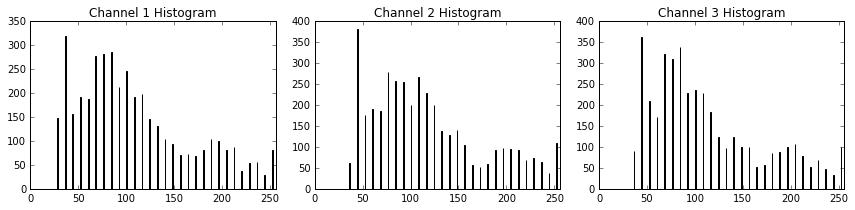

In [32]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, feature_vec[0*len(bin_centers):1*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, feature_vec[1*len(bin_centers):2*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, feature_vec[2*len(bin_centers):3*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

In [33]:
hls_carimage = convert_color(carimage, 'HLS')

In [34]:
feature_vec, bin_centers = features_color_hist(hls_carimage, nbins=num_color_bins, bins_range=color_bins_range)

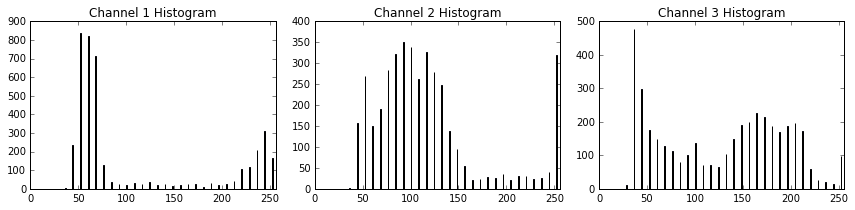

In [35]:
fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.bar(bin_centers, feature_vec[0*len(bin_centers):1*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 1 Histogram')
plt.subplot(132)
plt.bar(bin_centers, feature_vec[1*len(bin_centers):2*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 2 Histogram')
plt.subplot(133)
plt.bar(bin_centers, feature_vec[2*len(bin_centers):3*len(bin_centers)])
plt.xlim(0, 256)
plt.title('Channel 3 Histogram')
fig.tight_layout()

## HOG features

In [36]:
# HOG features and (optionally) visualization
# uses skimage implementation. Could be made faster using OpenCV, apparently, but did not have time to check.
# orient -- number of gradient orientation bins
# pix_per_cell -- size of cell we use for histogram
# cell_per_block -- for gamma normalization, how many blocks to normalize over
# viz -- whether to return the image version of HOG features
# feature_vec -- if True, return features as one vector. otherwise its multi-dimensional array
def features_hog(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # skimage.hog()
    r = hog(img,
            orientations = orient,
            pixels_per_cell = (pix_per_cell,pix_per_cell),
            cells_per_block = (cell_per_block,cell_per_block),
            visualise = vis,
            transform_sqrt=True, # gamma correction
            feature_vector = feature_vec)
    if vis == True:
        features, hog_image = r
        return features, hog_image
    else:      
        features = r
        return features

In [49]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

In [50]:
gray_image = cv2.cvtColor(carimage, cv2.COLOR_RGB2GRAY)

In [51]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=True)

CPU times: user 11.9 ms, sys: 966 µs, total: 12.8 ms
Wall time: 12 ms


In [52]:
hog_features.shape

(1764,)

In [53]:
hog_features

array([ 0.01041494,  0.00083086,  0.00484399, ...,  0.        ,
        0.        ,  0.        ])

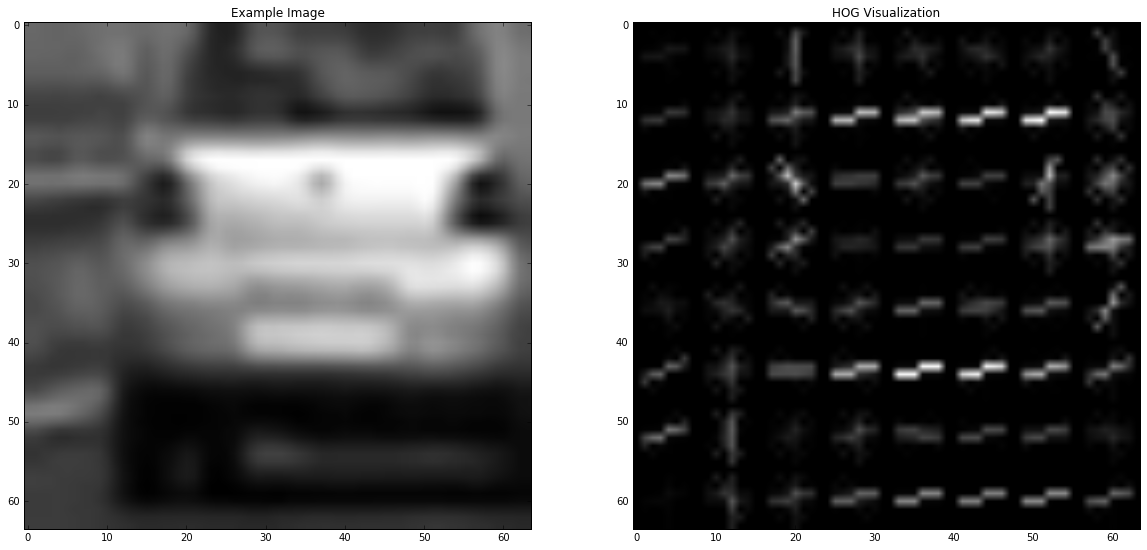

In [54]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

In [55]:
# convert to gray
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# only use lower half of the image
h, w = gray_image.shape
gray_image = gray_image[h//2:, :]

In [56]:
%time hog_features, hog_image = features_hog(gray_image, orient, pix_per_cell, cell_per_block, \
                                           vis=True, feature_vec=False)

CPU times: user 1.24 s, sys: 5.45 ms, total: 1.25 s
Wall time: 1.25 s


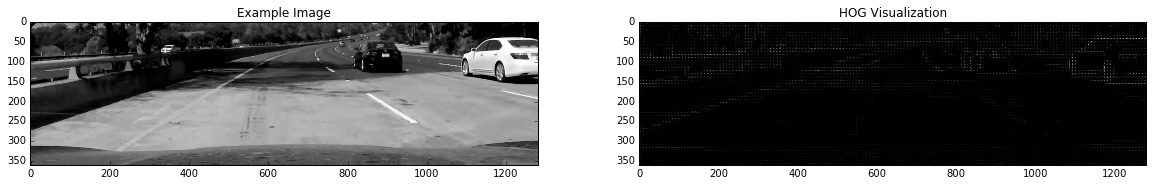

In [57]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Example Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization');

## combine and normalise features

In [357]:
def extract_features(images, 
                     to_colorspace='RGB', 
                     spatial_size=(32, 32),
                     hist_bins=32, 
                     hist_range=(0, 256),
                     hog_orient=9,
                     hog_pix_per_cell=8, 
                     hog_cell_per_block=2, 
                     hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for img in images:
        tmpimg = convert_color(img, to_colorspace=to_colorspace)
        
        spfeat = features_spatial(tmpimg, spatial_size, feature_vec=True)

        hfeat, bin_centers = features_color_hist(tmpimg, hist_bins, hist_range)
                
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hogfeat = []
            for channel in range(tmpimg.shape[2]):
                hogfeat.append(features_hog(tmpimg[:,:,channel], 
                                                   hog_orient, 
                                                   hog_pix_per_cell, 
                                                   hog_cell_per_block, 
                                                   vis=False, 
                                                   feature_vec=True))
            hogfeat = np.ravel(hogfeat)        
        else:
            hogfeat = features_hog(tmpimg[:,:,hog_channel], 
                                   hog_orient, 
                                   hog_pix_per_cell, 
                                   hog_cell_per_block, 
                                   vis=False, 
                                   feature_vec=True)        
        
        features.append(np.concatenate((spfeat, hfeat, hogfeat)))
#        features.append(np.concatenate((hfeat, hogfeat)))
#        features.append(hogfeat)
    return features

In [358]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
spatial_size = (32, 32)
hist_bins = 32
hist_range = (0, 256)
hog_orient = 9
hog_pix_per_cell = 8
hog_cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

In [359]:
allfeatures = extract_features(allimages, 
                                 to_colorspace=colorspace, 
                                 spatial_size=spatial_size,
                                 hist_bins=hist_bins, 
                                 hist_range=hist_range,
                                 hog_orient=hog_orient,
                                 hog_pix_per_cell=hog_pix_per_cell, 
                                 hog_cell_per_block=hog_cell_per_block, 
                                 hog_channel=hog_channel)

In [360]:
# scaler expects float64
allfeatures = np.array(allfeatures).astype(np.float64)

In [361]:
allimages.shape

(17760, 64, 64, 3)

In [362]:
allfeatures.shape

(17760, 8460)

In [363]:
feature_scaler = StandardScaler().fit(allfeatures)
scaled_features = feature_scaler.transform(allfeatures)

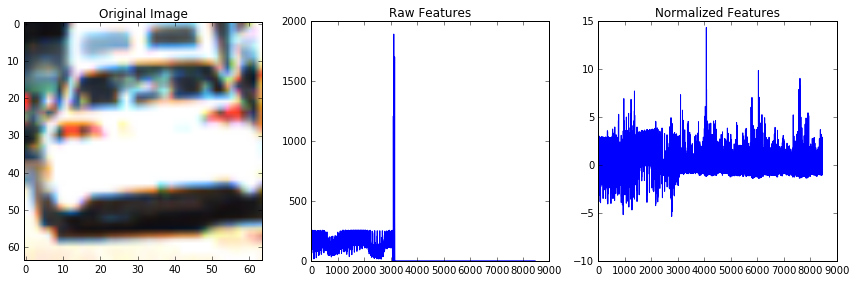

In [364]:
car_ind = np.random.randint(0, len(car_images))
# Plot an example of raw and scaled features
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(car_images[car_ind])
plt.title('Original Image')
plt.subplot(132)
plt.plot(allfeatures[car_ind])
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_features[car_ind])
plt.title('Normalized Features')
fig.tight_layout()

## train classifier

In [365]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_features, alllabels, test_size=0.2, random_state=rand_state)

In [569]:
print('Colorspace: '+colorspace)
print('Spatial binning size: {}'.format(spatial_size))
print('Color histogram bins: {}'.format(hist_bins))
print('Color histogram range: {}'.format(hist_range))
print('HOG orient: {}'.format(hog_orient))
print('HOG pix per cell: {}'.format(hog_pix_per_cell))
print('HOG cells per block: {}'.format(hog_cell_per_block))
print('HOG challen: {}'.format(hog_channel))
print('Feature vector length: {}'.format(len(X_train[0])))

classifier = LinearSVC()
#classifier = SVC(C=0.1, kernel='linear')
%time classifier.fit(X_train, y_train)

Colorspace: YUV
Spatial binning size: (32, 32)
Color histogram bins: 32
Color histogram range: (0, 256)
HOG orient: 9
HOG pix per cell: 8
HOG cells per block: 2
HOG challen: ALL
Feature vector length: 8460
CPU times: user 3.59 s, sys: 1.24 s, total: 4.82 s
Wall time: 4.98 s


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [570]:
print('Test Accuracy of classifier = ', round(classifier.score(X_test, y_test), 4))

n_predict = 30
%time pred = classifier.predict(X_test[0:n_predict])
print('Predicted: {}'.format(pred               ))
print('Actual   : {}'.format(y_test[0:n_predict]))

n_predict = 1500
%time pred = classifier.predict(X_test[0:n_predict])


Test Accuracy of classifier =  0.993
CPU times: user 1.19 ms, sys: 183 µs, total: 1.37 ms
Wall time: 366 µs
Predicted: [1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1]
Actual   : [1 0 1 0 1 1 0 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1 1 1 1]
CPU times: user 39.2 ms, sys: 504 µs, total: 39.7 ms
Wall time: 9.98 ms


In [269]:
n_predict=30
classifier.decision_function(X_test[0:n_predict])>0.6

array([False,  True,  True,  True, False,  True, False,  True,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True], dtype=bool)

## sliding windows

In [69]:
# draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

In [503]:
# Generate sliding windows coordinates.
# Takes an image,
# start and stop positions in both x and y,
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, 
                 x_start_stop=[None, None], 
                 y_start_stop=[None, None],
                 window_size = (64, 64), 
                 window_overlap_fraction = (0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    h, w, _ = img.shape
    x_start = 0 if x_start_stop[0] is None else x_start_stop[0]
    y_start = 0 if y_start_stop[0] is None else y_start_stop[0]
    x_stop  = w if x_start_stop[1] is None else x_start_stop[1]
    y_stop  = h if y_start_stop[1] is None else y_start_stop[1]
    # Compute the span of the region to be searched
    x_span = x_stop - x_start
    y_span = y_stop - y_start
    # Compute the number of pixels per step in x/y
    x_step = int(float(window_size[0])*window_overlap_fraction[0])
    y_step = int(float(window_size[1])*window_overlap_fraction[1])
    # Compute the number of windows in x/y
    x_windows = x_span // x_step
    y_windows = y_span // y_step
    # make windows list
    window_list = []
    for x in range(x_start,x_stop,x_step):
        for y in range(y_start,y_stop,y_step):
            window = ((x,y),(x+window_size[0],y+window_size[1]))
            window_list.append(window)
    return window_list

160

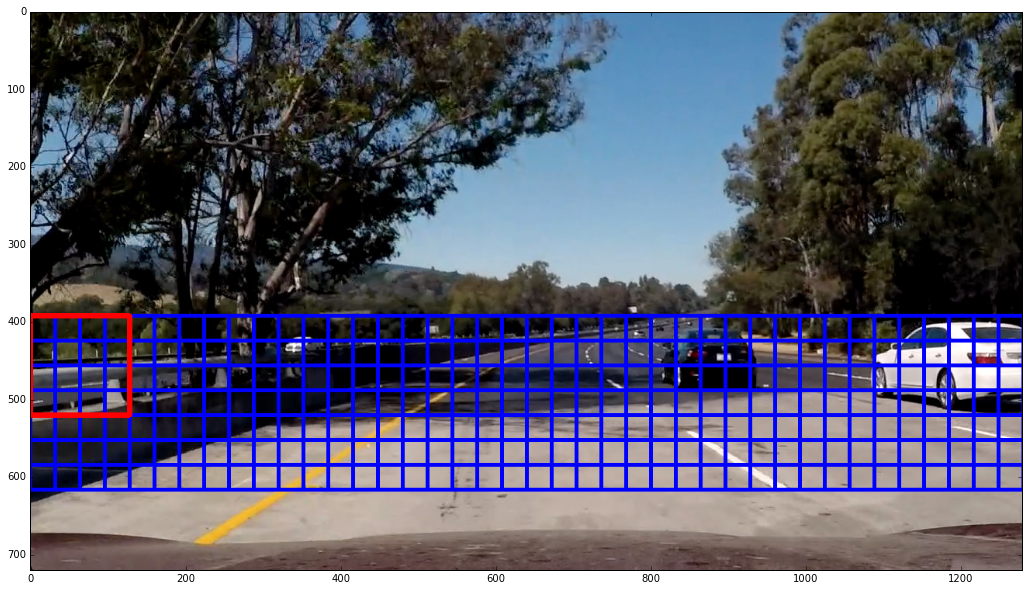

In [517]:
windows128 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(128, 128), 
                       window_overlap_fraction=(0.25, 0.25))
window_img = draw_boxes(image, windows128, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows128[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows128)

252

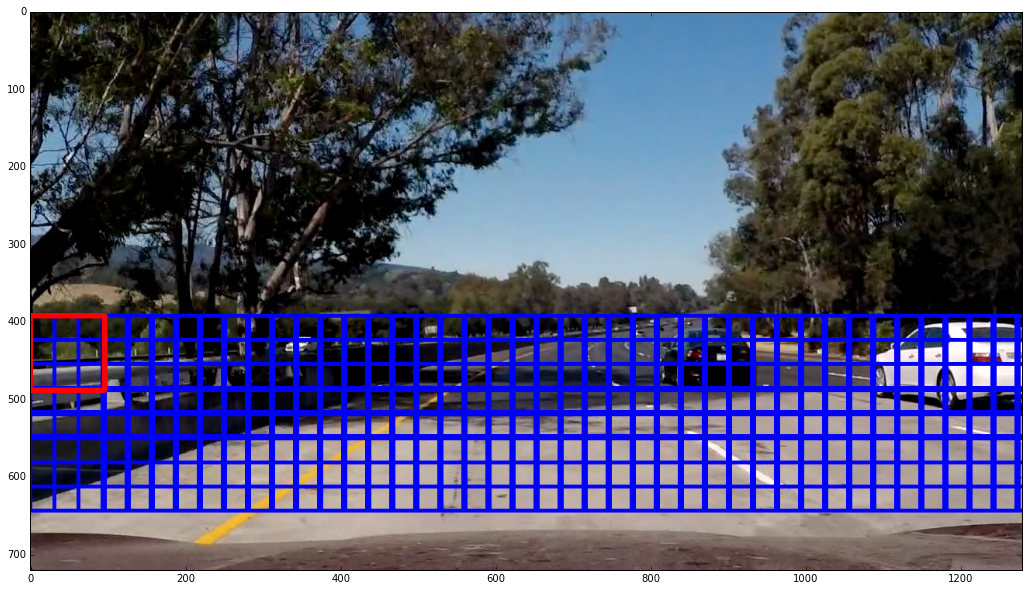

In [518]:
windows96 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128+32],
                       window_size=(96, 96), 
                       window_overlap_fraction=(0.33, 0.33))
window_img = draw_boxes(image, windows96, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows96[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows96)

640

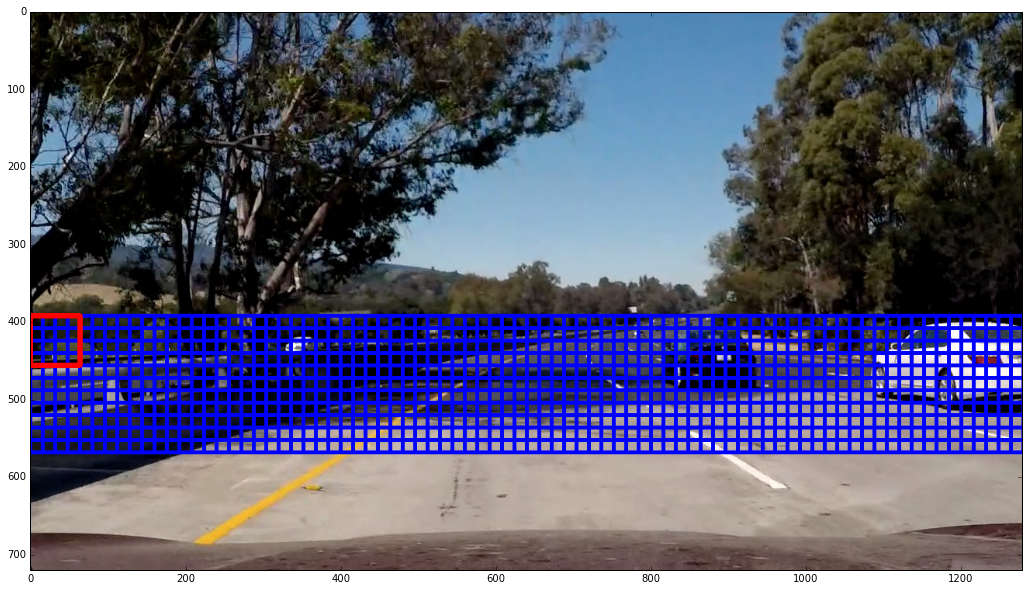

In [519]:
windows64 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(64, 64), 
                       window_overlap_fraction=(0.25, 0.25))
window_img = draw_boxes(image, windows64, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows64[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows64)

90

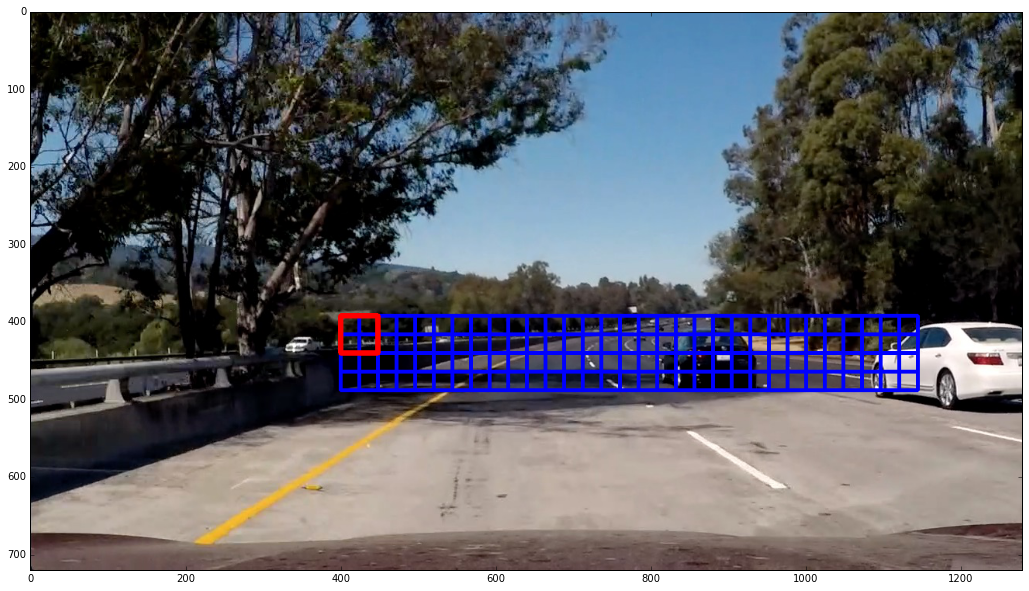

In [520]:
windows48 = slide_window(image, 
                       x_start_stop=[400, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+64],
                       window_size=(48, 48), 
                       window_overlap_fraction=(0.5, 0.5))
window_img = draw_boxes(image, windows48, color=(0, 0, 255), thick=3)
window_img = draw_boxes(window_img, (windows48[0],), color=(255, 0, 0), thick=6)
plt.imshow(window_img);
len(windows48)

In [521]:
windows = windows128 + windows96 + windows64 + windows48

In [522]:
windows = windows128 + windows64

In [523]:
#windows = windows96 + windows64

In [524]:
len(windows)

800

## search and classify

In [493]:
# Predict for each window in the image.
# Extracts features at each window position, and predicts with classifier
def search_windows(img, 
                   windows, 
                   classifier, 
                   scaler, 
                   decision_function_threshold = 0.0,
                   classifier_input_size = (64, 64),
                   colorspace = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   hog_orient = 9, 
                   hog_pix_per_cell = 8, 
                   hog_cell_per_block = 2, 
                   hog_channel = 0):

    test_imgs = np.zeros((len(windows), classifier_input_size[0], classifier_input_size[1], 3), np.uint8)
    for i,window in enumerate(windows):
        # extract the test window from original image
        test_imgs[i,:,:,:] = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], classifier_input_size)

    # TODO: do HOG features for entire image. multiple scales?
    features = extract_features(images = test_imgs, 
                                to_colorspace = colorspace, 
                                spatial_size = spatial_size,
                                hist_bins = hist_bins, 
                                hist_range = hist_range,
                                hog_orient = hog_orient,
                                hog_pix_per_cell = hog_pix_per_cell, 
                                hog_cell_per_block = hog_cell_per_block, 
                                hog_channel = hog_channel)
    features = np.array(features).astype(np.float64)
    scaled_features = scaler.transform(features)

    #pred2 = classifier.predict(scaled_features)
    decisions = classifier.decision_function(scaled_features)
    pred = decisions>decision_function_threshold
    pred2 = np.zeros_like(pred)
    pred2[pred] = 1
    
    # positive detection windows
    on_windows = [windows[i] for i,p in enumerate(pred2) if p==1]
    decision_values = [decisions[i] for i,p in enumerate(pred2) if p==1]
    
    return on_windows, decision_values

In [547]:
classifier_input_size = carimage.shape[0:2]
decision_function_threshold = 0.3

In [548]:
%time hot_windows, decision_values = search_windows(img = image, \
                             windows = windows, \
                             classifier = classifier, \
                             scaler = feature_scaler, \
                             decision_function_threshold = decision_function_threshold, \
                             classifier_input_size = classifier_input_size, \
                             colorspace = colorspace, \
                             spatial_size = spatial_size, \
                             hist_bins = hist_bins, \
                             hist_range = hist_range, \
                             hog_orient = hog_orient, \
                             hog_pix_per_cell = hog_pix_per_cell, \
                             hog_cell_per_block = hog_cell_per_block, \
                             hog_channel = hog_channel)

CPU times: user 6.54 s, sys: 59.2 ms, total: 6.6 s
Wall time: 6.61 s


In [549]:
len(hot_windows)

18

In [550]:
decision_values[0:5]

[1.9519043258066042,
 3.0721999816978043,
 0.34119939163353996,
 0.60429627861324398,
 0.9162372187013107]

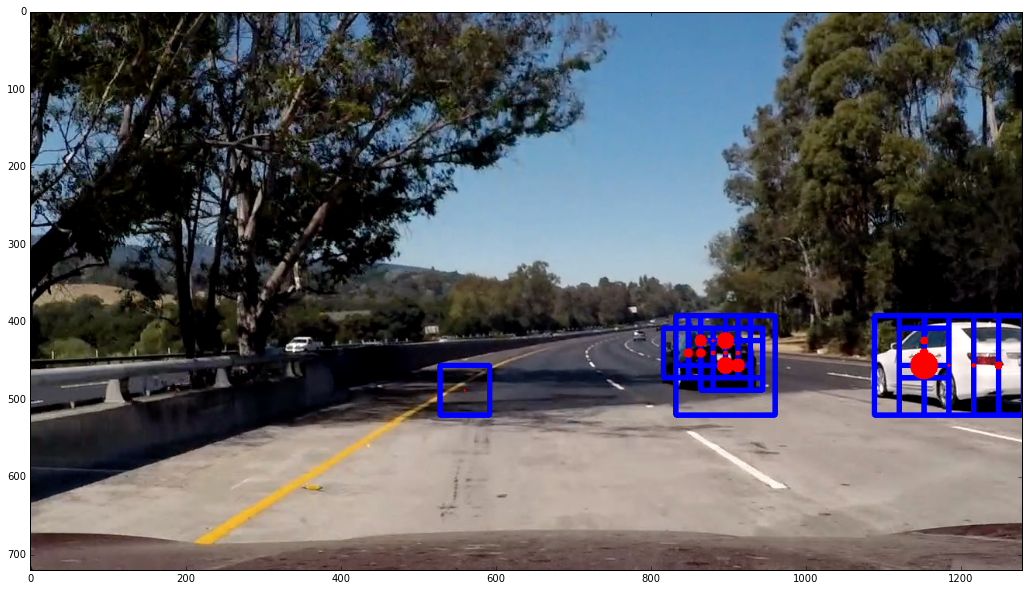

In [551]:
# draw found window matches, along with their centers. the point in center is proportional to decision function value
window_img = draw_boxes(image, hot_windows, color=(0, 0, 255), thick=6)
centroids = [((b[0][0]+b[1][0])//2, (b[0][1]+b[1][1])//2) for b in hot_windows]
for i,p in enumerate(centroids):
    cv2.circle(window_img, p, radius=int(6*decision_values[i]), color=(255,0,0), thickness=-1)
plt.imshow(window_img);

## produce heatmaps and identify car bounding boxes

In [386]:
def apply_threshold(heatmap, threshold):
    heatmap[heatmap <= threshold] = 0
    return heatmap

In [573]:
def make_heatmap(heatmap, bbox_list, decision_values=None, heatmap_individual_threshold=None):
    heatmap = heatmap.astype(np.float32)
    for i,box in enumerate(bbox_list):
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        weight = 1 if decision_values is None else decision_values[i]
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0 * weight
    # apply individual threshold
    if heatmap_individual_threshold is not None:
        heatmap2 = apply_threshold(heatmap, heatmap_individual_threshold)
    else:
        heatmap2 = heatmap
    # scale to 0-255
    m = np.max(heatmap2)
    return (heatmap2 * (255/m)).astype(np.uint8)

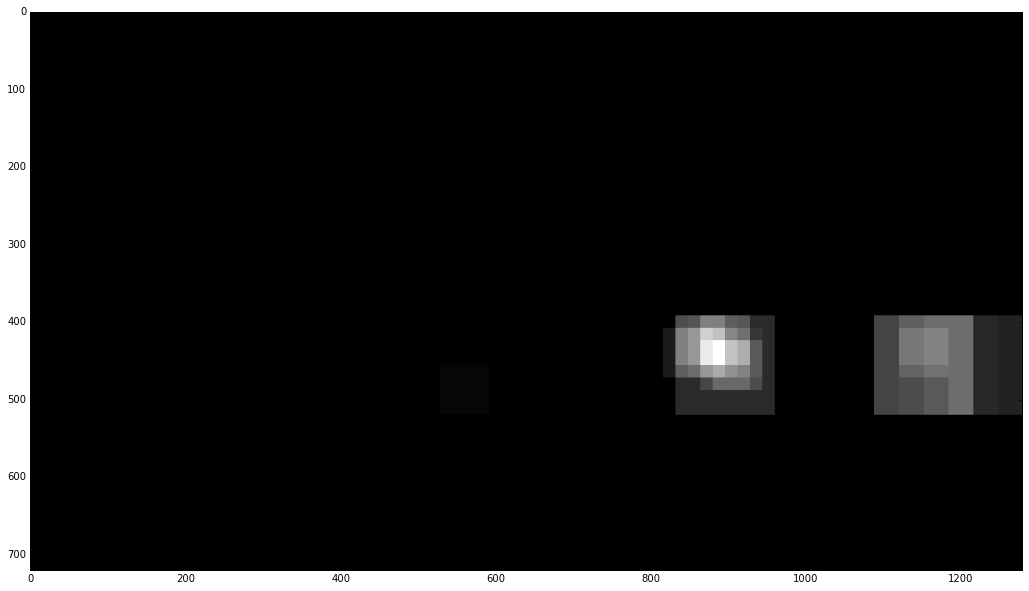

In [574]:
heatmap = np.zeros_like(image[:,:,0])
heatmap = make_heatmap(heatmap, hot_windows, decision_values)
plt.imshow(heatmap, cmap='gray');

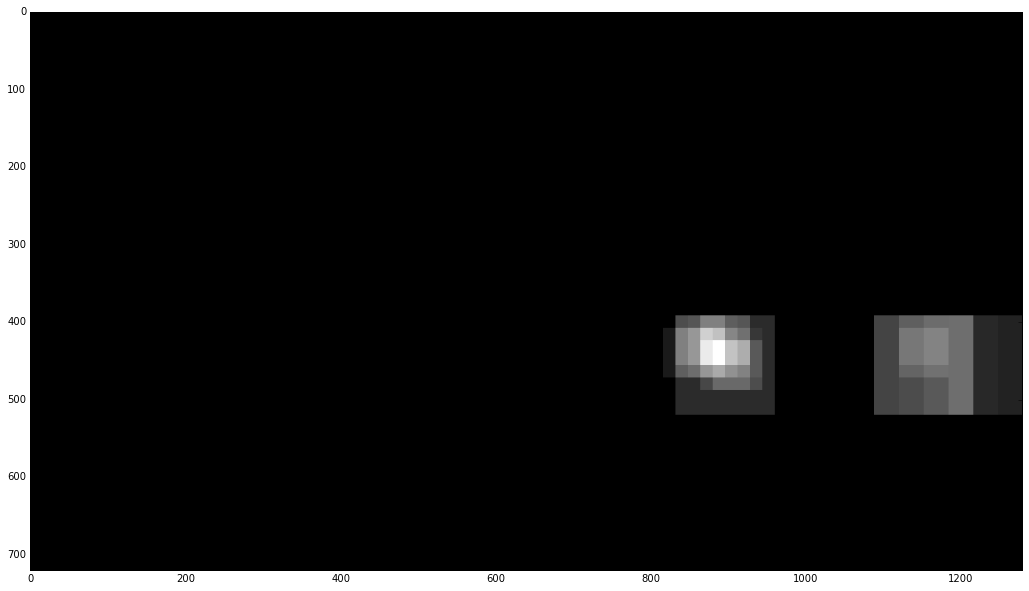

In [557]:
thresh = 20
plt.imshow(apply_threshold(heatmap, thresh), cmap='gray');

In [558]:
# from scipy.ndimage.measurements
labels = label(heatmap)
labels[1]

2

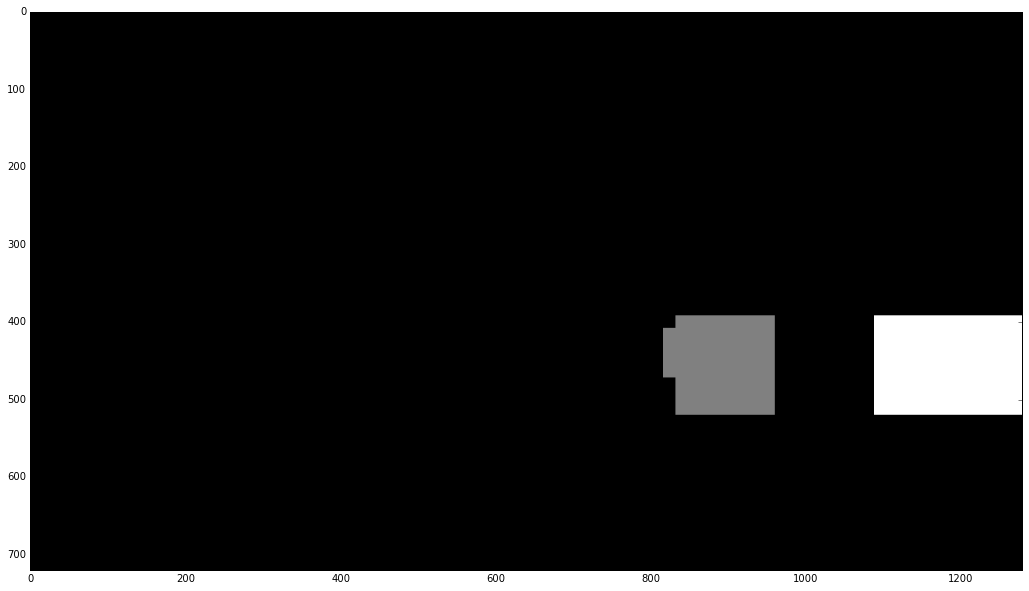

In [559]:
plt.imshow(labels[0], cmap='gray');

In [599]:
# Given areas of non-zero pixels identified by 'labels' function produce a bounding box
# for each identified area.
# It skips boxes which are too small or out of proportion that are unlikely to be cars.
def draw_labeled_bboxes(img, labels):
    bboxes = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # skip boxes which do not look realistic. too small in one dimension or too 'vertical'
        w = bbox[1][0] - bbox[0][0]
        h = bbox[1][1] - bbox[0][1]
        if w<30 or h<30 or w==0 or float(h)/float(w) > 4./3.:
            continue
        # Draw the box on the image and return it
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        bboxes.append(bbox)
    # Return the image
    return img, bboxes

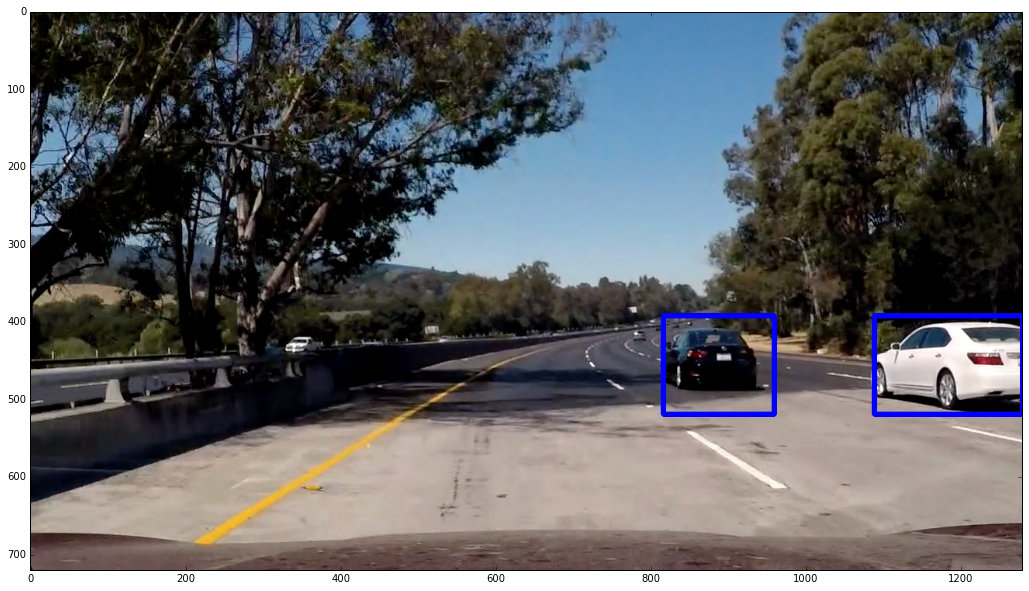

In [600]:
draw_img, bboxes = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img);

## combine pipeline into one class

In [605]:
class VehicleDetector:
    
    def __init__(self, feature_scaler, classifier, classifier_input_size,
                   decision_function_threshold,
                   heatmap_threshold, # average thresholding, for heatmap normalised 0-255
                   heatmap_individual_threshold, # single-frame thresholding, number of overlapping windows
                   lookback_length = 5,
                   colorspace = 'RGB', 
                   spatial_size = (32, 32), 
                   hist_bins = 32, 
                   hist_range = (0, 256), 
                   hog_orient = 9, 
                   hog_pix_per_cell = 8, 
                   hog_cell_per_block = 2, 
                   hog_channel = 0):
        
        self._frame_number = 0
        self._bboxes_deque = deque(maxlen=lookback_length)
        self._heatmap_deque = deque(maxlen=lookback_length)
        
        self._feature_scaler = feature_scaler
        self._classifier = classifier
        self._classifier_input_size = classifier_input_size

        self._decision_function_threshold = decision_function_threshold
        self._heatmap_threshold = heatmap_threshold
        self._heatmap_individual_threshold = heatmap_individual_threshold
        
        self._colorspace = colorspace
        self._spatial_size = spatial_size 
        self._hist_bins = hist_bins 
        self._hist_range = hist_range
        self._hog_orient = hog_orient
        self._hog_pix_per_cell = hog_pix_per_cell
        self._hog_cell_per_block = hog_cell_per_block
        self._hog_channel = hog_channel
        
        self.define_windows()
    
    def define_windows(self):
        windows128 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(128, 128), 
                       window_overlap_fraction=(0.25, 0.25))
        windows96 = slide_window(image, 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128+32],
                       window_size=(96, 96), 
                       window_overlap_fraction=(0.33, 0.33))
        windows64 = slide_window(image, 
                       #x_start_stop=[200, 1100], 
                       x_start_stop=[None, None], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+128],
                       window_size=(64, 64), 
                       window_overlap_fraction=(0.25, 0.25))
        windows48 = slide_window(image, 
                       x_start_stop=[400, 1100], 
                       y_start_stop=[image.shape[0]//2+32, image.shape[0]//2+32+64],
                       window_size=(48, 48), 
                       window_overlap_fraction=(0.5, 0.5))
        #self._search_windows = windows128 + windows96 + windows64 + windows48
        self._search_windows = windows128 + windows64 
        #self._search_windows = windows96 + windows64 
        
    def process_image(self, img, debug=False):
        hot_windows, decision_values = search_windows(img = img, \
                             windows = self._search_windows, \
                             classifier = self._classifier, \
                             scaler = self._feature_scaler, \
                             decision_function_threshold = self._decision_function_threshold, \
                             classifier_input_size = self._classifier_input_size, \
                             colorspace = self._colorspace, \
                             spatial_size = self._spatial_size, \
                             hist_bins = self._hist_bins, \
                             hist_range = self._hist_range, \
                             hog_orient = self._hog_orient, \
                             hog_pix_per_cell = self._hog_pix_per_cell, \
                             hog_cell_per_block = self._hog_cell_per_block, \
                             hog_channel = self._hog_channel)        
        
        self._frame_number += 1

        heatmap = np.zeros_like(img[:,:,0])
        heatmap = make_heatmap(heatmap, hot_windows, decision_values, self._heatmap_individual_threshold)
        #thresh_heatmap = apply_threshold(heatmap, self._heatmap_individual_threshold)
        thresh_heatmap = heatmap # do not apply threshold to individual frames, just do it for sum later
        self._heatmap_deque.append(thresh_heatmap)
        
        # take heatmap sum over last few frames
        a = np.array(vdetector._heatmap_deque)
        avgheatmap = np.sum(a, axis=0).astype(np.float32) / len(self._heatmap_deque)
        # remove low 30 percentile of heatmap
        #avgheatmap[avgheatmap<np.max(avgheatmap)*.2] = 0
        # apply threshold to the rest
        avgheatmap = apply_threshold(avgheatmap, self._heatmap_threshold) 

        #labels = label(thresh_heatmap)
        labels = label(avgheatmap)
        
        # Draw bounding boxes on a copy of the image
        draw_img, bboxes = draw_labeled_bboxes(np.copy(img), labels)
        self._bboxes_deque.append(bboxes)

        # put frame number and car count on the image
        s = 'frame: {}'.format(self._frame_number)
        font = cv2.FONT_HERSHEY_TRIPLEX
        cv2.putText(draw_img, s, (50,50), 
                    font, fontScale=0.7, color=(255,255,0), lineType=cv2.LINE_AA)
        s = 'cars: {}'.format(len(bboxes))
        font = cv2.FONT_HERSHEY_TRIPLEX
        cv2.putText(draw_img, s, (50,70), 
                    font, fontScale=0.7, color=(255,255,0), lineType=cv2.LINE_AA)
        
        # return final result
        if not debug:
            return draw_img
        else:
            window_img = draw_boxes(img, hot_windows, color=(0, 0, 255), thick=6)
            centroids = [((b[0][0]+b[1][0])//2, (b[0][1]+b[1][1])//2) for b in hot_windows]
            for i,p in enumerate(centroids):
                cv2.circle(window_img, p, radius=int(6*decision_values[i]), color=(255,0,0), thickness=-1)

            return draw_img, window_img, heatmap, avgheatmap, labels # should really be returning bboxes, but lets leave for now
        
    def process_diagnostic_view(self, image):
        annotated_image, windows, heatmap, thresholded_heatmap, labels = self.process_image(img = image, debug=True)
        
        (height, width, _) = annotated_image.shape
        diagnostic_view = np.zeros((height*2, width, 3), dtype=np.uint8)
        diagnostic_view[0:height, 0:width] = annotated_image
        rh = int(height/2)
        rw = int(width/2)
        # raw windows
        diagnostic_view[height:(height+rh), 0:(rw), :] = cv2.resize(windows, (rw,rh), interpolation=cv2.INTER_AREA) 
        # heatmap
        m = np.max(heatmap)
        img = cv2.cvtColor(heatmap*(255/m).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        diagnostic_view[height:(height+rh), rw:(2*rw), :] = cv2.resize(img, (rw,rh), interpolation=cv2.INTER_AREA) 
        # thresholded heatmap
        m = np.max(thresholded_heatmap)
        img2 = cv2.cvtColor(thresholded_heatmap*(255/m).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        diagnostic_view[(height+rh):(height+2*rh), 0:(rw), :] = cv2.resize(img2, (rw,rh), interpolation=cv2.INTER_AREA) 
        # labelled heatmap
        m = np.max(labels[0])
        img3 = cv2.cvtColor((labels[0]*(255/m)).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        diagnostic_view[(height+rh):(height+2*rh), rw:(2*rw), :] = cv2.resize(img3, (rw,rh), interpolation=cv2.INTER_AREA) 
        return diagnostic_view


In [606]:
classifier_input_size = carimage.shape[0:2]
decision_function_threshold = 0.3 # anything higher we'll take as a car
heatmap_individual_threshold = 1
heatmap_threshold = 50
lookback_length = 10

In [607]:
vdetector = VehicleDetector(feature_scaler = feature_scaler, 
                            classifier = classifier, 
                            classifier_input_size = classifier_input_size,
                            decision_function_threshold = decision_function_threshold,
                            heatmap_individual_threshold = heatmap_individual_threshold,
                            heatmap_threshold = heatmap_threshold,
                            lookback_length = 1,
                            colorspace = colorspace, 
                            spatial_size = spatial_size, 
                            hist_bins = hist_bins, 
                            hist_range = hist_range, 
                            hog_orient = hog_orient, 
                            hog_pix_per_cell = hog_pix_per_cell, 
                            hog_cell_per_block = hog_cell_per_block, 
                            hog_channel = hog_channel)

CPU times: user 2.29 s, sys: 57.3 ms, total: 2.34 s
Wall time: 2.19 s


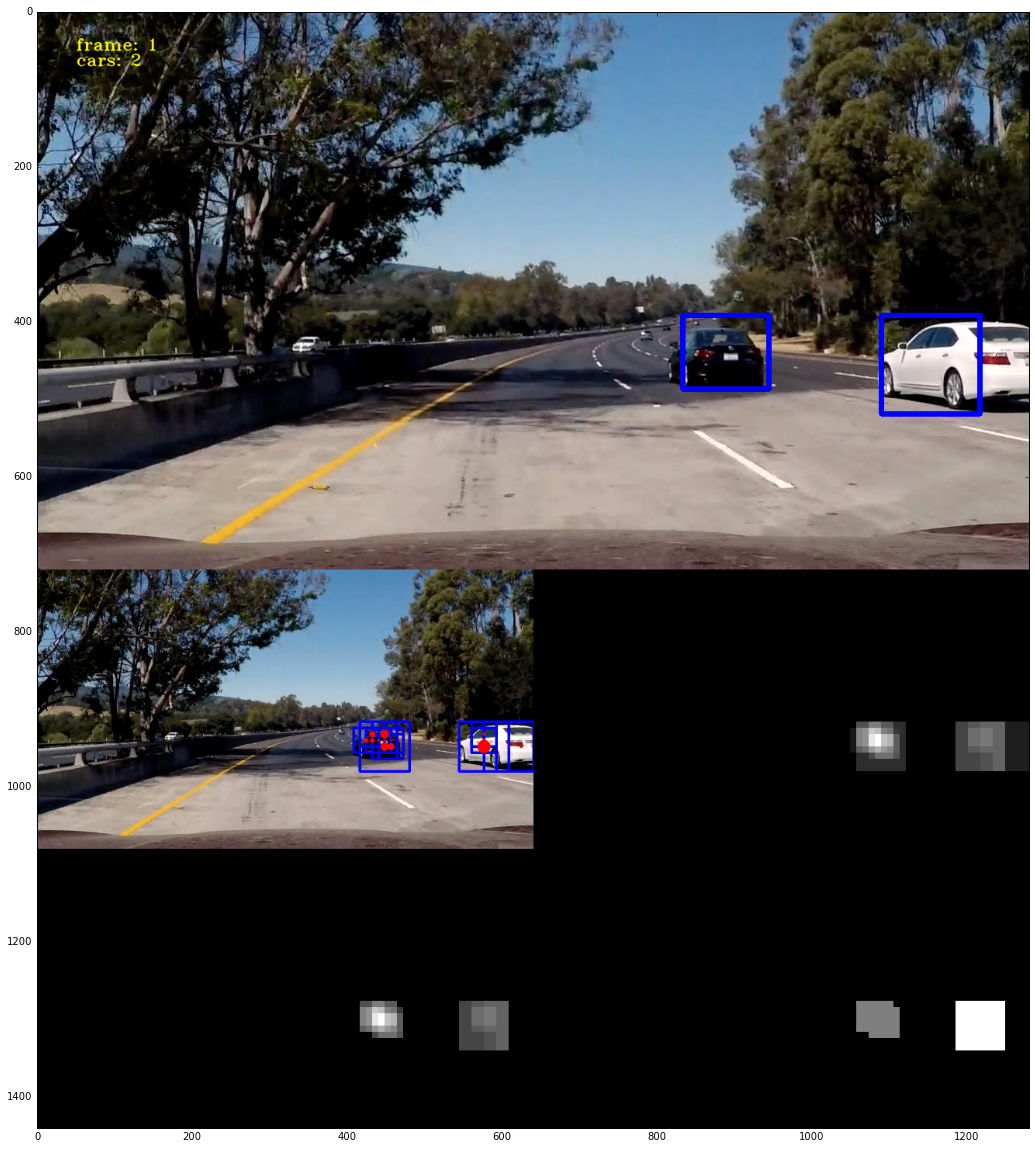

In [608]:
%time dview = vdetector.process_diagnostic_view(image)
fig = plt.figure(figsize=(20,20))
plt.imshow(dview);

In [ ]:
%time annotated_image, window_image, heatmap, thresh_heatmap, labels = vdetector.process_image(img = image, debug=True)

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.subplot(321)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(322)
plt.imshow(window_image)
plt.title('Raw Windows')
plt.subplot(323)
m = np.max(heatmap)
plt.imshow(heatmap*(255/m), cmap='gray');
plt.title('Heatmap')
plt.subplot(324)
m = np.max(thresh_heatmap)
plt.imshow(thresh_heatmap*(255/m), cmap='gray');
plt.title('Thresholded Heatmap')
plt.subplot(325)
plt.imshow(labels[0], cmap='gray')
plt.title('Labeled Heatmap: {} cars'.format(labels[1]))
plt.subplot(326)
plt.imshow(annotated_image);
plt.title('Final Image')
fig.tight_layout()

## profiling

In [ ]:
import cProfile, pstats, io

In [ ]:
pr = cProfile.Profile()
pr.enable()
annotated_image = vdetector.process_image(img = image, debug=False)
pr.disable()
s = io.StringIO()
sortby = 'tottime'
ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
ps.print_stats()
print(s.getvalue())

## video processing

In [609]:
vdetector = VehicleDetector(feature_scaler = feature_scaler, 
                            classifier = classifier, 
                            classifier_input_size = classifier_input_size,
                            decision_function_threshold = decision_function_threshold,
                            heatmap_individual_threshold = heatmap_individual_threshold,
                            heatmap_threshold = heatmap_threshold,
                            lookback_length = lookback_length,
                            colorspace = colorspace, 
                            spatial_size = spatial_size, 
                            hist_bins = hist_bins, 
                            hist_range = hist_range, 
                            hog_orient = hog_orient, 
                            hog_pix_per_cell = hog_pix_per_cell, 
                            hog_cell_per_block = hog_cell_per_block, 
                            hog_channel = hog_channel)

In [610]:
#input_clip = VideoFileClip("project_video.mp4")
input_clip = VideoFileClip("project_video_annotated.mp4")
#input_clip = VideoFileClip("project_video_annotated_short.mp4")
#input_clip = VideoFileClip("project_video_annotated.mp4").subclip(26, 37)
#input_clip = VideoFileClip("project_video_annotated.mp4").subclip(37, 39)
#input_clip = VideoFileClip("project_video_annotated.mp4").subclip(0, 1)

annotated_output = 'project_video_annotated3.mp4'
#annotated_output = 'project_video_annotated_test.mp4'
#annotated_output = 'project_video_annotated_short.mp4'

In [611]:
#annotated_clip = input_clip

In [ ]:
#%time annotated_clip = input_clip.fl_image(vdetector.process_image) #NOTE: this function expects color images!!
%time annotated_clip = input_clip.fl_image(vdetector.process_diagnostic_view) #NOTE: this function expects color images!!

CPU times: user 2.28 s, sys: 93.7 ms, total: 2.37 s
Wall time: 2.19 s


In [ ]:
annotated_clip.write_videofile(annotated_output, audio=False)

[MoviePy] >>>> Building video project_video_annotated3.mp4
[MoviePy] Writing video project_video_annotated3.mp4


 68%|██████▊   | 856/1261 [32:04<15:09,  2.25s/it]

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(annotated_output))

In [ ]:
vdetector._bboxes_deque

In [ ]:
[b for b in vdetector._bboxes_deque]

In [ ]:
[(x1, y1, x2, y2) for ((x1, y1),(x2,y2)) in vdetector._bboxes_deque]

In [ ]:
np.mean(vdetector._bboxes_deque)

In [ ]:
imgcopy = np.zeros_like(image)
for b in vdetector._bboxes_deque:
    imgcopy = draw_boxes(imgcopy, b, color=(0, 0, 255), thick=3)
plt.imshow(imgcopy);


In [ ]:
vdetector._heatmap_deque

In [ ]:
vdetector._heatmap_deque[0].shape

In [ ]:
a = np.array(vdetector._heatmap_deque)

In [ ]:
np.sum(a, axis=0).shape

In [ ]:
avgheatmap = np.sum(a, axis=0)

In [ ]:
np.unique(avgheatmap)

In [ ]:
51*.8

In [ ]:
plt.imshow(avgheatmap);

In [ ]:
avgheatmap[avgheatmap<np.max(avgheatmap)*.2] = 0

In [ ]:
plt.imshow(avgheatmap);

In [ ]:
labels = label(avgheatmap)
draw_img, bboxes = draw_labeled_bboxes(np.copy(image), labels)
plt.imshow(draw_img);